In [99]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
import os

os.environ["EIA_KEY"] = 'fe03a56c771ae5fa830d067afee42e27'

import eiapy

mpl.rcParams["figure.facecolor"] = 'White'

def convert(d):
    try:
        return float(d.replace(',',''))
    except:
        return d
def moving_average(a, n=3) :
    a = list(a)
    a2 = np.concatenate((np.flip(a[:(int(n/2))]),a,np.flip(a[-(int((n-1)/2)):])))
    ret = np.cumsum(a2, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
def getSublist(listA,nsub):
    listB = list(np.linspace(0,len(listA)-1,nsub).astype(int))
    res = list(map(listA.__getitem__,listB))
    return res,listB


reader = open('name-abbr.csv')

csv_dict = {}
nrows = 0
for row in reader.readlines():
    row = row.strip('\n')
    row = row.replace('"','')
    key,value = row.split(',')
    csv_dict[key.lower()] = value
reader.close()

state_name_map = csv_dict  
# print(state_name_map)
del state_name_map["district of columbia"]

def extract_rate(call,year=2021):
    rates = eiapy.Series(call)
    res = rates.get_data(start=year-1,end=year)
    return res['series'][0]['data'][0][1]

def get_state_e_rate(state,year=2021):

    res = 'ELEC.PRICE.'+state+'-RES.A'
    com = 'ELEC.PRICE.'+state+'-COM.A'
    gas = 'NG.N3020'+state+'3.A'
    return {'res':extract_rate(res,year),'com':extract_rate(com,year),'gas':extract_rate(gas,year)}



res_ids = []
com_ids = []
gas_ids = []
solar_gen_ids = []
wind_gen_ids = []
all_gen_ids = []
for state in state_name_map.values():
    res = 'ELEC.PRICE.{}-RES.A'.format(state)
    com = 'ELEC.PRICE.{}-COM.A'.format(state)
    gas = 'NG.N3020{}3.A'.format(state)
    solar = 'ELEC.GEN.TSN-{}-99.A'.format(state)
    wind = 'ELEC.GEN.WND-{}-99.A'.format(state)
    all_gen = 'ELEC.GEN.ALL-{}-99.A'.format(state)
    res_ids.append(res)
    com_ids.append(com)
    gas_ids.append(gas)
    solar_gen_ids.append(solar)
    wind_gen_ids.append(wind)
    all_gen_ids.append(all_gen)

all_ids = {
    'res':res_ids,
    'com':com_ids,
    'gas':gas_ids,
    'solar':solar_gen_ids,
    'wind':wind_gen_ids,
    'all_gen':all_gen_ids
}
years = set()
state_data_all = {}
for key,ids in all_ids.items():
    multi_res = eiapy.MultiSeries(ids)
    raw_data = multi_res.get_data(start=2005,end=2020)['series']

    for val in raw_data:
        state = val['geography'].split('-')[-1]
        if state not in state_data_all.keys():
            state_data_all[state] = {id:{} for id in all_ids.keys()}
        for year,value in val['data']:
            state_data_all[state][key][int(year)] = value
            years.add(int(year))
# print(years)


Text(0, 0.5, 'Wind + Solar Penetration (%)')

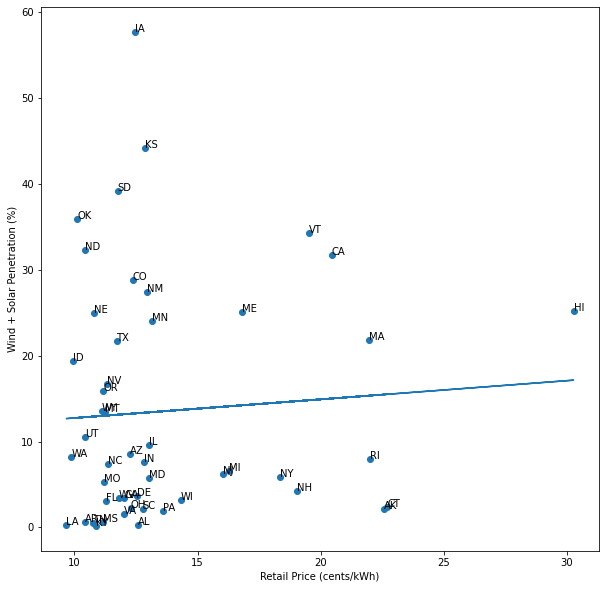

In [100]:
from sklearn.linear_model import LinearRegression
plt.figure(figsize=(10,10))
year = 2020
xs = []
ys = []
txts = []
for state,data in state_data_all.items():
    def get_val(key):
        rv = 0.0
        try:
            rv = data[key][year]
        except:
            rv = 0.0
        return rv

    res = get_val('res')
    solar = get_val('solar')
    wind = get_val('wind')
    all = get_val('all_gen')

    frac = (wind+solar)/all
    ys.append(100*frac)
    xs.append(res)
    txts.append(state)

xs2 = np.array(xs).reshape(-1,1)
ys2 = np.array(ys).reshape(-1,1)
reg = LinearRegression().fit(xs2,ys2)
y2 = reg.predict(xs2)
plt.scatter(xs,ys)
plt.plot(xs,y2)
for (x,y,t) in zip(xs,ys,txts):
    plt.annotate(t,(x,y))     
plt.xlabel('Retail Price (cents/kWh)')
plt.ylabel('Wind + Solar Penetration (%)')

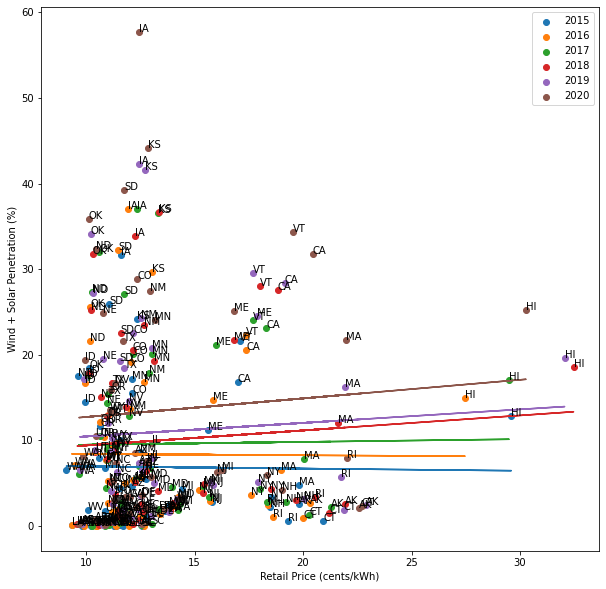

In [101]:
plt.figure(figsize=(10,10))
for year in range(2015,2021,1):
    xs = []
    ys = []
    txts = []
    for state,data in state_data_all.items():
        def get_val(key):
            rv = 0.0
            try:
                rv = data[key][year]
            except:
                rv = 0.0
            return rv

        res = get_val('res')
        solar = get_val('solar')
        wind = get_val('wind')
        all = get_val('all_gen')

        frac = (wind+solar)/all
        ys.append(100*frac)
        xs.append(res)
        txts.append(state)

    xs2 = np.array(xs).reshape(-1,1)
    ys2 = np.array(ys).reshape(-1,1)
    reg = LinearRegression().fit(xs2,ys2)
    y2 = reg.predict(xs2)
    plt.scatter(xs,ys,label=str(year))
    plt.plot(xs,y2)

    for (x,y,t) in zip(xs,ys,txts):
        plt.annotate(t,(x,y))     
plt.xlabel('Retail Price (cents/kWh)')
plt.ylabel('Wind + Solar Penetration (%)')
plt.legend()

(0.0, 60.970334955145994)

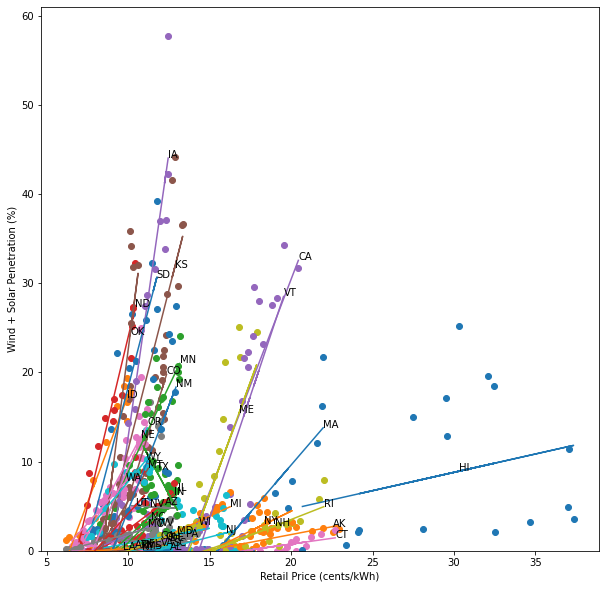

In [104]:
plt.figure(figsize=(10,10))
for state,data in state_data_all.items():
    xs = []
    ys = []
    txts = []
    
    for year in sorted(years):
        def get_val(key):
            rv = 0.0
            try:
                rv = data[key][year]
            except:
                rv = 1.0e-6
            return rv

        res = get_val('res')
        solar = get_val('solar')
        wind = get_val('wind')
        all = get_val('all_gen')

        frac = (wind+solar)/all
        ys.append(100*frac)
        xs.append(res)
        txts.append(state)

    xs2 = np.array(xs).reshape(-1,1)
    ys2 = np.array(ys).reshape(-1,1)
    reg = LinearRegression().fit(xs2,ys2)
    y2 = reg.predict(xs2)
    plt.scatter(xs,ys)
    plt.plot(xs,y2)

    plt.annotate(state,(xs[-1],y2[-1]),zorder=999)     
plt.xlabel('Retail Price (cents/kWh)')
plt.ylabel('Wind + Solar Penetration (%)')
plt.ylim(bottom=0)
